In [17]:

from time import time
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import tomotopy as tp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier

In [12]:
from sklearn import metrics
from sklearn.utils.extmath import density

In [2]:
plt.style.use("fivethirtyeight")

## Load  and explore the Tripadvisor dataset

In [3]:
df = pd.read_csv("../sampleData/tripadvisorReviews/hotel_reviews.csv")

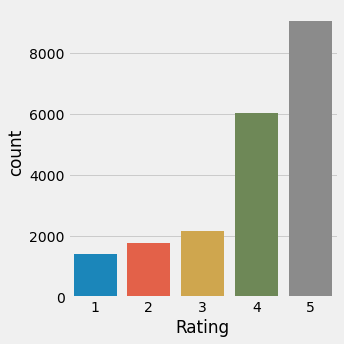

In [4]:
sns.catplot(x="Rating", data=df, kind="count");

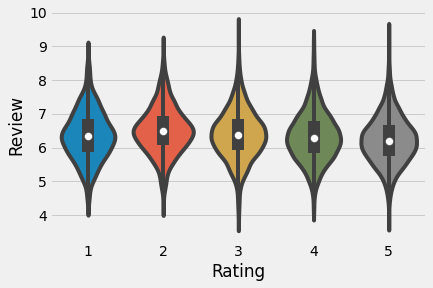

In [5]:
sns.violinplot(x="Rating", y=np.log(df.loc[:, "Review"].str.len()), data=df);

## Data transformation

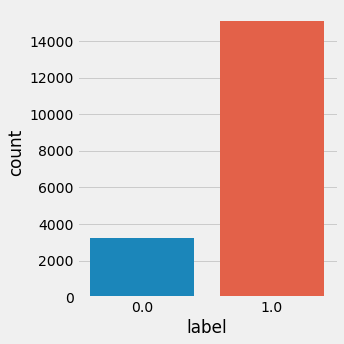

In [6]:
# review class
df.loc[:, "label"] = np.nan
# good review
df.loc[df["Rating"] < 3, "label"] = int(0)
df.loc[df["Rating"] > 3, "label"] = int(1)
# distribution of reviwes across labels
sns.catplot(x="label", data=df.loc[df["label"].notnull()], kind="count");

In [7]:
# bad reviews
bad = df.loc[df["label"] == 0, ["Review", "label"]]
# good reviews
good = df.loc[df["label"] == 1, ["Review", "label"]]
good = good.sample(n=len(bad), random_state=42)
# combine good and bad reviews
s = pd.concat([bad, good])

## Text pre-processing

In [42]:
# nlp pipeline
nlp = spacy.load("en_core_web_sm")
# pass reviews through the pipeline
docs = nlp.pipe(
    s.loc[:, "Review"].str.lower(), n_process=2, batch_size=500, disable=["tok2vec"],
)
tkns_docs = []
for doc in docs:
    tmp = []
    for token in doc:
        if (
            token.is_stop == False
            and token.is_punct == False
            and token.like_num == False
        ):
            tmp.append(token.lemma_)
    tkns_docs.append(tmp)
    del tmp

## Train competing LDA models and evaluate them

In [43]:
# create a corpus using tp utilities
corpus = tp.utils.Corpus()
# populate the corpus
for item in tkns_docs:
    corpus.add_doc(words=item)
# search for the best fitting model
mf = {}
for i in range(10, 260, 10):
    print(">>> Working on the model with {} topics >>>\n".format(i), flush=True)
    mdl = tp.LDAModel(k=i, corpus=corpus, min_df=5, rm_top=5, seed=42)
    mdl.train(0)
    for j in range(0, 1000, 10):
        mdl.train(10)
        print("Iteration: {}\tLog-likelihood: {}".format(j, mdl.ll_per_word))
    coh = tp.coherence.Coherence(mdl, coherence="u_mass")
    mf[i] = coh.get_score()
    mdl.save("k_{}".format(i), True)


>>> Working on the model with 10 topics >>>

Iteration: 0	Log-likelihood: -8.636813976532249
Iteration: 10	Log-likelihood: -8.3316916234269
Iteration: 20	Log-likelihood: -8.21998928846974
Iteration: 30	Log-likelihood: -8.147362056882866
Iteration: 40	Log-likelihood: -8.102707117823758
Iteration: 50	Log-likelihood: -8.070046239300778
Iteration: 60	Log-likelihood: -8.048714678717063
Iteration: 70	Log-likelihood: -8.033698917700733
Iteration: 80	Log-likelihood: -8.022071900709335
Iteration: 90	Log-likelihood: -8.010991539945282
Iteration: 100	Log-likelihood: -8.004748624393281
Iteration: 110	Log-likelihood: -8.00145474423978
Iteration: 120	Log-likelihood: -7.996596885734148
Iteration: 130	Log-likelihood: -7.989248514040618
Iteration: 140	Log-likelihood: -7.984768193259234
Iteration: 150	Log-likelihood: -7.979400738244818
Iteration: 160	Log-likelihood: -7.979162080628406
Iteration: 170	Log-likelihood: -7.978005162272914
Iteration: 180	Log-likelihood: -7.973615744451644
Iteration: 190	Log-l

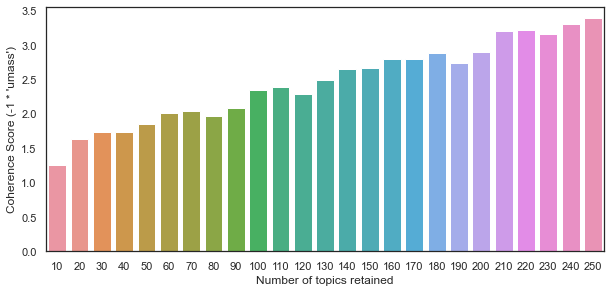

In [71]:
fig = plt.figure(figsize=(10, 4.5))
ax = fig.add_subplot(111)
sns.barplot(x=list(mf.keys()), y=[-1*score for score in mf.values()], ax=ax)
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence Score (-1 * 'umass')")
plt.show()

## Get document-to-topic probabilities

In [8]:
best_mdl = tp.LDAModel.load("k_250")

In [9]:
td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)

In [9]:
td.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6428 entries, 0 to 6427
Data columns (total 250 columns):
 #    Column     Non-Null Count  Dtype  
---   ------     --------------  -----  
 0    topic_1    6428 non-null   float32
 1    topic_2    6428 non-null   float32
 2    topic_3    6428 non-null   float32
 3    topic_4    6428 non-null   float32
 4    topic_5    6428 non-null   float32
 5    topic_6    6428 non-null   float32
 6    topic_7    6428 non-null   float32
 7    topic_8    6428 non-null   float32
 8    topic_9    6428 non-null   float32
 9    topic_10   6428 non-null   float32
 10   topic_11   6428 non-null   float32
 11   topic_12   6428 non-null   float32
 12   topic_13   6428 non-null   float32
 13   topic_14   6428 non-null   float32
 14   topic_15   6428 non-null   float32
 15   topic_16   6428 non-null   float32
 16   topic_17   6428 non-null   float32
 17   topic_18   6428 non-null   float32
 18   topic_19   6428 non-null   float32
 19   topic_20   6428 non-null 

/tmp/ipykernel_963663/1060493533.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  td.info(verbose=True, null_counts=True)


## Text classification task

### Train-test split

In [10]:
X, y = td.loc[:, ].values, s.loc[:, "label"].values

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


In [ ]:
### Classification

In [51]:
ridge_c = RidgeClassifier(alpha=0.75, random_state=0, fit_intercept=False)

In [52]:
ridge_c.fit(X_train, y_train)

RidgeClassifier(alpha=0.75, fit_intercept=False, random_state=0)

In [53]:
ridge_c.n_features_in_

250

In [54]:
ridge_c.coef_

array([[-2.32329547e-01, -1.36275518e+00,  9.46456969e-01,
        -5.44722855e-01,  3.01159918e-01,  6.21804953e-01,
         7.62498379e-02, -3.52686584e-01,  3.54623646e-01,
         5.50630867e-01,  2.01423213e-01,  3.95610511e-01,
        -3.52994132e+00,  5.32669686e-02, -1.00139284e+00,
         3.58932108e-01,  2.71056086e-01, -2.28132352e-01,
        -7.02128589e-01,  4.59787488e-01, -2.06638122e+00,
         1.48378742e+00,  2.90149003e-01,  2.69489903e-02,
         1.79585487e-01, -2.39423409e-01,  8.95319104e-01,
         1.06626189e+00,  6.60437346e-01,  5.56649745e-01,
        -2.37785602e+00,  1.27175653e+00, -1.33877516e+00,
        -1.81286067e-01, -4.50821102e-01,  1.21886127e-01,
        -2.67053425e-01, -1.28652704e+00,  4.24465150e-01,
        -1.01810110e+00,  8.26480538e-02, -6.38846338e-01,
        -1.30024123e+00, -3.56992149e+00,  9.85166609e-01,
        -1.98047197e+00,  1.56635679e-02,  6.51245952e-01,
        -2.57683992e-01, -4.70378071e-01, -1.36065796e-0

In [55]:
ridge_c.score(X_test, y_test)

0.9086314152410575